In [6]:
#----Imports----#
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

In [7]:
#----DTW Function Definitions----#
def euclidean_distance(p: tuple, q: tuple)-> float:
    """
    @description: Computes the euclidean distance between two points
    @param       {tuple} p: (x1, y1)
    @param       {tuple} q: (x2, y2)
    @return      {float} Euclidean distance between p and q
    """
    return np.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

def dtw(seq1: list, seq2: list)-> tuple:
    """
    @description: Computes the DTW distance between two sequences
    @param       {list} seq1: -
    @param       {list} seq2: -
    @return      {tuple} (DTW distance, local errors)
    """
    m, n = len(seq1), len(seq2)
    dtw_matrix = np.full((m+1, n+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in tqdm(range(1, m+1), desc="Computing DTW", ncols=100):
        for j in range(1, n+1):
            cost = euclidean_distance(seq1[i-1], seq2[j-1])
            dtw_matrix[i, j] = cost + min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
    
    # Extracting the warping path for local errors
    path = []
    i, j = m, n
    while i > 0 or j > 0:
        path.append((i, j))
        min_index = np.argmin([dtw_matrix[i-1, j-1], dtw_matrix[i, j-1], dtw_matrix[i-1, j]])
        if min_index == 0:
            i, j = i-1, j-1
        elif min_index == 1:
            i, j = i, j-1
        else:
            i, j = i-1, j
    path.reverse()
    
    # Computing local errors using the warping path
    local_errors = [euclidean_distance(seq1[i-1], seq2[j-1]) for i, j in path]
    
    return dtw_matrix[m, n], local_errors

In [8]:
#----Data Managing----#
def extract_data_from_file(filename: str)-> list:
    """
    @description: Extracts data from a file
    @param       {str} filename: Name of the file
    @return      {list} List of data points
    """
    data_points = []
    with open(filename, 'r') as file:
        for line in file:
            values = line.split(',')
            x = float(values[1].strip())
            y = float(values[2].strip())
            data_points.append((x, y))
    return data_points

def save_errors_to_file(local_error: float)-> None:
    """
    @description: Saves the error data to a file
    @param       {list} folders: list of folders
    @param       {list} errors: dtw distances
    @param       {list} local_errors: local errors
    @return      {*} None
    """
    # Save DTW distances and local errors
    with open('LT_Error.txt', 'w') as f:
        f.write(str(local_error) + '\n')

def read_errors_from_file(folders: list) -> (list, list):
    """
    @description: Reads the error data from files
    @param       {list} folders: list of folders from which to read errors
    @return      {tuple}: dtw distances (list) and local errors (list of lists)
    """
    errors = []
    local_errors_list = []

    # Check if Errors directory exists
    if not os.path.exists('Errors'):
        raise ValueError("The 'Errors' directory does not exist.")

    # Read DTW distances
    with open(os.path.join('Errors', 'dtw_distances.txt'), 'r') as f:
        for line in f:
            errors.append(float(line.strip()))

    # Read local errors for each folder
    for folder in folders:
        local_errors = []
        with open(os.path.join('Errors', f'local_errors_{folder}.txt'), 'r') as f:
            for line in f:
                local_errors.append(float(line.strip()))
        local_errors_list.append(local_errors)

    # Trim local errors to the length of the shortest sequence
    min_length = min([len(local_errors) for local_errors in local_errors_list])
    for idx, local_errors in enumerate(local_errors_list):
        local_errors_list[idx] = local_errors[:min_length]

    return errors, local_errors_list


In [9]:
#----Global Variables----#
# FOLDERS = ['12']
# FOLDERS = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
RECORD_DATA_CUTOFF = 5800
X_LIM = (0, 6)
Y_LIM = (-4, 1)
ERRORS = []
LOCAL_ERRORS = []
RECORD_DATA = []
TEST_DATA = []

In [10]:
# Read and plot record_data.txt as reference
RECORD_DATA = extract_data_from_file('LT_Record_Data.txt')
RECORD_DATA = RECORD_DATA[:RECORD_DATA_CUTOFF]

folder_path = 'LT_Data.txt'
TEST_DATA= extract_data_from_file(folder_path)
dtw_distance, local_errors = dtw(RECORD_DATA, TEST_DATA)
print(f'DTW distance for {folder_path}: {dtw_distance}')
# Save DTW distances and local errors to files
save_errors_to_file(local_errors)

Computing DTW: 100%|███████████████████████████████████████████| 5800/5800 [00:08<00:00, 678.15it/s]

DTW distance for LT_Data.txt: 896.4247784850892


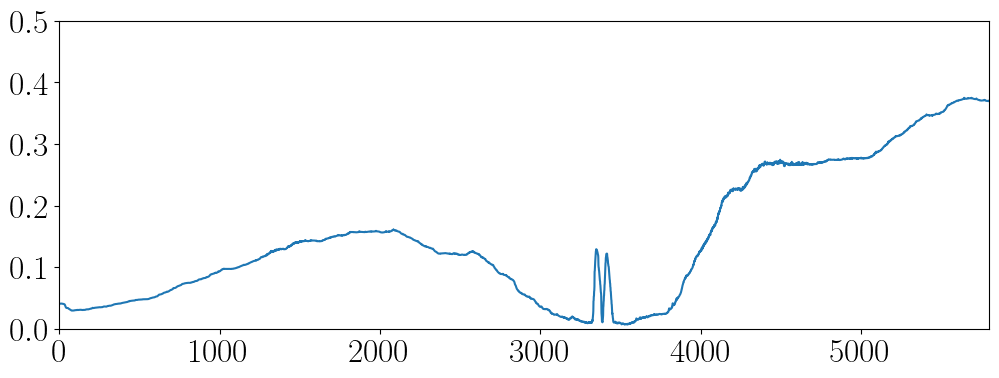

In [11]:
# Plotting local error for all the test datas
plt.rc("font", family = "serif")
plt.rc("text", usetex = True)
plt.rc("xtick", labelsize = 24)
plt.rc("ytick", labelsize = 24)
plt.rc("figure", figsize = (12, 4))
plt.rc("legend", fontsize = 18)
plt.rc("axes", titlesize = 30)
plt.rc("axes", labelsize = 30)
plt.xlim(0, RECORD_DATA_CUTOFF)
plt.ylim(0, 0.5)
plt.yticks(np.arange(0, 0.51, 0.1))

plt.plot(local_errors, label="Local Error")

# plt.title("Positional Errors V.S. Waypoints (Right Turn)", pad=10)
# plt.xlabel("Waypoint Index")
# plt.ylabel("Positional Error (m)")
# plt.legend(loc='upper left')
# plt.grid(True)

# Optionally save the figure before showing
plt.savefig("LT_Errors.pdf", bbox_inches="tight")
plt.show()

Animating: 100%|█████████▉| 5918/5922 [01:29<00:00, 67.80it/s]

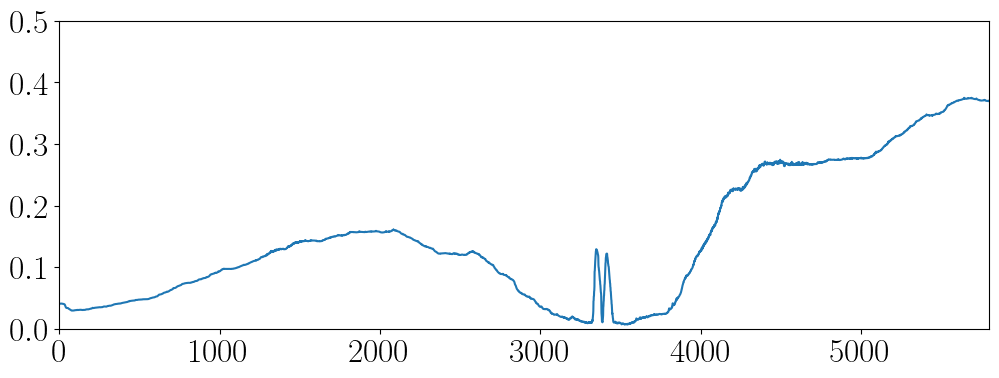

Animating: 100%|██████████| 5922/5922 [01:29<00:00, 66.25it/s]


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming local_errors and RECORD_DATA_CUTOFF are defined somewhere above

# Setting up the figure, the axis, and the plot elements
fig, ax = plt.subplots(figsize=(12, 4))

# Apply rc configurations
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
plt.rc("xtick", labelsize=24)
plt.rc("ytick", labelsize=24)
plt.rc("figure", figsize=(12, 4))
plt.rc("legend", fontsize=18)
plt.rc("axes", titlesize=30)
plt.rc("axes", labelsize=30)

ax.set_xlim(0, RECORD_DATA_CUTOFF)
ax.set_ylim(0, 0.5)
ax.set_yticks(np.arange(0, 0.51, 0.1))
line, = ax.plot([], [], label="Local Error")
progress_bar = tqdm(total=len(local_errors), desc="Animating", position=0, leave=True)

# Initialization function: sets up a clean slate.
def init():
    line.set_data([], [])
    return line,

# The update function for each frame
def update(frame):
    # Here, frame is a value from 0 to the length of local_errors
    # We're gradually revealing the data over the course of the animation
    progress_bar.update(1)
    line.set_data(range(frame), local_errors[:frame])
    return line,

# The duration of the animation in milliseconds
duration = 24.78 * 1000

# Calculate the interval based on the number of data points
interval = duration / len(local_errors)

ani = FuncAnimation(fig, update, frames=len(local_errors), init_func=init, blit=True, interval=interval, repeat=False)

# Optionally save the animation to a file before showing
ani.save("LT_Errors_Animation.mp4", writer="ffmpeg", extra_args=['-vcodec', 'libx264'])

plt.show()
progress_bar.close()